In [1]:
%matplotlib inline


# Procedure graphs (and the handshaking theorem)

Raphael Leung

Our team recently made some ontologies for statutory instruments for an SI tracker in time for Brexit secondary legislation. 

You can represent procedures in many ways (say, different RDF serialization formats or different tree/graph data structures). But often the most intuitive way of explaining it is just to draw out the steps and show how they lead to other steps. 

This is a directed cyclic graph -- you can think of procedures as many dyads ("procedure routes") with two nodes which are from and to steps ("procedure steps"). There's direction (a step causes/allows/precludes another etc), hence directed. And there are self-loops, hence cyclic.

For work I tried turning this graph into different types of graph formats. E.g. 
Graphviz/DOT ([docs](https://www.graphviz.org/)): [procedures.azurewebsites.net/procedures/4/graph.dot](http://procedures.azurewebsites.net/procedures/4/graph.dot) and 
GraphML ([docs](http://graphml.graphdrawing.org/primer/graphml-primer.html)): [procedures.azurewebsites.net/procedures/4/graph.graphml](http://procedures.azurewebsites.net/procedures/4/graph.graphml).

Along the way, I discovered some interesting tidbits of how we commonly represent and analyze graphs. So this is my brief forray into the massive universe of network analysis...

### First, fetch the data

In [2]:
import requests

r = requests.get("http://procedures.azurewebsites.net/Procedures/4/graph.graphml")
print r.status_code
with open('procedure.graphml', 'w') as f:
    f.write(r.text)

200


I'd been told by people who study networks that GraphML is one of the preferred formats. It's XML-based, fairly straight forward, and can be loaded into and out of common tools like Gephi, yEd, etc.

I wanted to try loading it into `networkx`, a sexy python package that seems to have a lot of built-in graph analysis functionality, without the need to download a local software GUI etc. I decided to use a slightly older version of the package (when their read_graphml function was more lax) which isn't compatible with python 3+ why this is in python 2.7.. The `read_graphml` method only take file paths, so it's saved to disk instead of loaded from memory.

Since it's an XML format, you can parse the data in that format if you want to. Here are 5 edges with their vertices, e.g..

In [3]:
from xml.etree import ElementTree as ET
import itertools

root = ET.fromstring(r.text)
graph = root[1]
print graph

ns = {'graphml': 'http://graphml.graphdrawing.org/xmlns'}
    
for route in itertools.islice(graph.findall('graphml:edge', ns), 35, 40):
    fromStep = route.get('source')
    toStep = route.get('target')
    print fromStep,'-->', toStep

<Element '{http://graphml.graphdrawing.org/xmlns}graph' at 0xa593be0>
https://id.parliament.uk/ADYK7qyp --> https://id.parliament.uk/nveorPPO
https://id.parliament.uk/dnWpdwUf --> https://id.parliament.uk/FYeLHMEw
https://id.parliament.uk/EQvIVxb9 --> https://id.parliament.uk/VQx4bcZV
https://id.parliament.uk/FYeLHMEw --> https://id.parliament.uk/JqzvdWEL
https://id.parliament.uk/ADYK7qyp --> https://id.parliament.uk/M28y2NsI


### Load into networkx

In [4]:
import networkx as nx

G = nx.read_graphml("procedure.graphml")
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 42
Number of edges: 89
Average in degree:   2.1190
Average out degree:   2.1190


### Plot a degree count histogram

One of the most common ways to describe a graph is its degree distribution. 

For each vertex degree count is simply the count of the number of edges (in/out) connected to it. And degree centrality weights this with num of nodes, so it's fraction of nodes (0-1). 

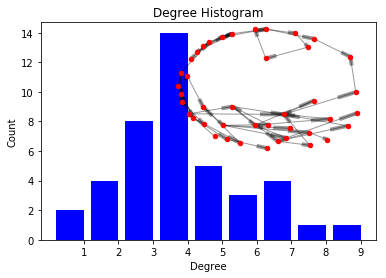

In [10]:
from collections import Counter 
import matplotlib.pyplot as plt

def get_degree_dist(G):
    degree_sequence = sorted(list(G.degree().values()), reverse=True) 
    return Counter(degree_sequence)

def plot_degree_hist(G):
    if not isinstance(G, Counter):
        g = get_degree_dist(G)
    
    degree, count = zip(*g.items())

    fig, ax = plt.subplots()
    plt.bar(degree, count, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in degree])
    ax.set_xticklabels(degree)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.weakly_connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.show()
    
plot_degree_hist(G)

Can see it's bit right skewed, There's a tail so may be "hubs" (a few very well connected nodes which you don't see in a random graph). 

If there's a power law distribution, these graphs are called "[scale-free](https://mathinsight.org/scale_free_network)" (presence of large hubs). For larger sized graphs, can plot log-log of the fraction of nodes against degree. Look for a downward linear relationship to confirm.

Refer to [docs](https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_histogram.html) for more. 

### There're other centrality measures:

In [6]:
import operator
print "Nodes with highest"

# Most well-connected
print "Degree:", sorted(nx.degree(G).items(), key=operator.itemgetter(1), reverse=True)[0]
print "Degree centrality:", sorted(nx.degree_centrality(G).items(), key=operator.itemgetter(1), reverse=True)[0]

# "How quickly anyone can get to it" - ave length of shortest path between node and all other nodes in graph
print "Closeness centrality:", sorted(nx.closeness_centrality(G).items(), key=operator.itemgetter(1), reverse=True)[0]

# Most "influence" - measures connection to better-connected/ high-scoring nodes
print "Eigenvector centrality:", sorted(nx.eigenvector_centrality_numpy(G).items(), key=operator.itemgetter(1), reverse=True)[0]

# "How central" - measures how many times node acts as a bridge in shortest path
print "Betweenness centrality:", sorted(nx.betweenness_centrality(G).items(), key=operator.itemgetter(1), reverse=True)[0]

Nodes with highest
Degree: ('https://id.parliament.uk/ORYEPBmc', 9)
Degree centrality: ('https://id.parliament.uk/ORYEPBmc', 0.21951219512195122)
Closeness centrality: ('https://id.parliament.uk/wShvPQbP', 0.20959073997519634)
Eigenvector centrality: ('https://id.parliament.uk/VQx4bcZV', 0.9747210731142247)
Betweenness centrality: ('https://id.parliament.uk/nVheFQgh', 0.06707317073170732)


Pick the right centrality measure to use for a particular graph. But note there are criticisms of these measures too, because connection != influence. So these centrality measures of nodes may not capture importance of edges. 

And besides centrality measures there's assortativity to measure core vs periphery. 

### If you want to draw it...

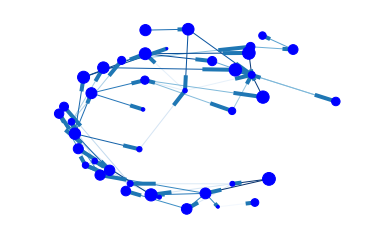

In [11]:
from __future__ import division

pos = nx.layout.spring_layout(G)

node_sizes = [0 + 4 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=1)

ax = plt.gca()
ax.set_axis_off()
plt.show()

Or you can load it into Gephi, yEd or SocNetV, etc. Where you can tweak ways to show attributes with edge weights or node size or color/ change the topology or layout algorithms. Viz tends to look better there. Or use d3.

Here are some examples of different layouts in yEd.


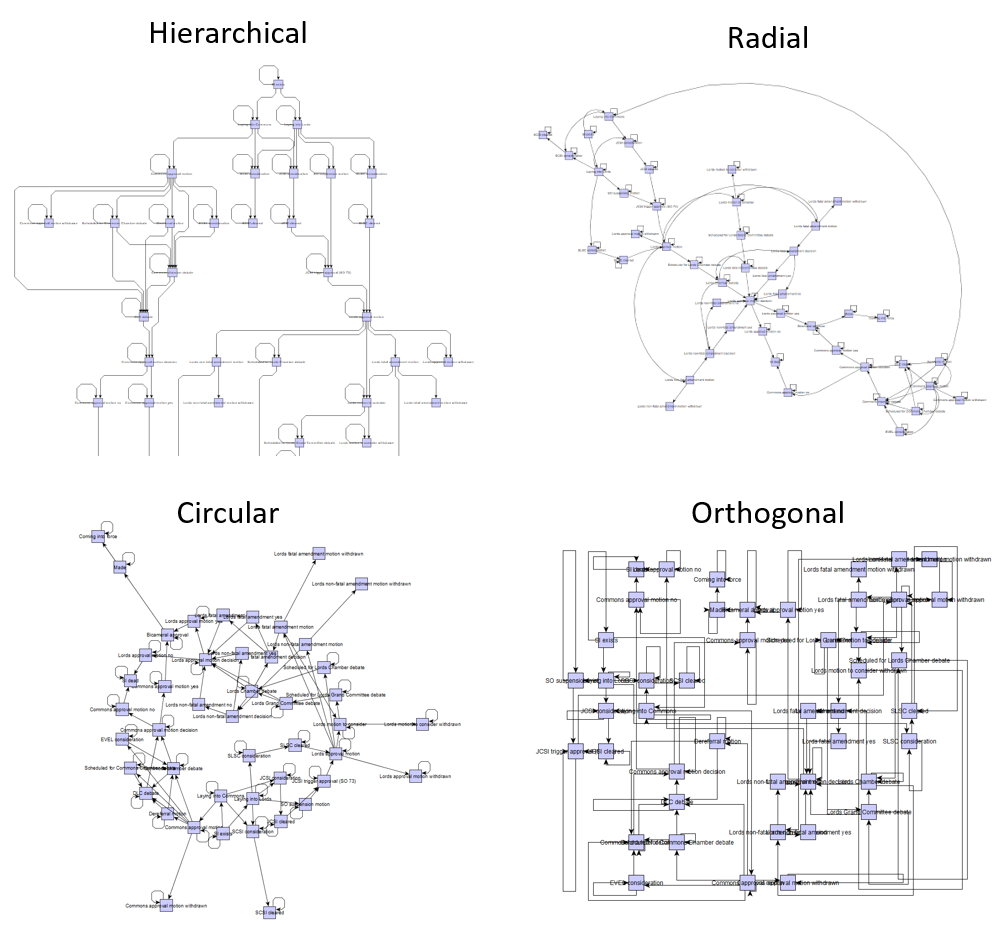

In [8]:
from IPython.display import Image
Image(filename='graphExamples.png')

### Or export it to other common data structures 

e.g you may want an adjacency matrix if you want to do DFS (which you can't do with edgelists).

In [9]:
# nx.to_edgelist(G)
nx.to_numpy_matrix(G)

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

### And.. Handshaking theorem

One last thing -- notice average in and out degrees were the same?

`Average in degree:   2.1190
Average out degree:   2.1190`

Apparently for all graphs, sum of in degree = sum of out degree, according to the [Handshaking Theorem](https://en.wikipedia.org/wiki/Handshaking_lemma) in graph theroy!

Scenario: People shake hands in a room and individually keep count of how many people they shook hands with. Let's call this number "degree". Then those with an even degree steps to one side of the room and those with odd degree to the other.
- There'll always be an even number of people whose individual handshake count is odd ("even odd degree")
- Sum of everyone's handshake counts = 2E, where E = # of edges/ handshakes

We can think of handshaking as directed, same as our directed graph example. Now instead of keeping tracking of 1 number, everyone keeps track of 2 -- number of handshakes received (in degree) and initiated (out degree).
- (Sum of everyone's in degree) and (sum of everyone's out degrees) are the same! (each being E, where E = # of edges)

Like in the NBA, if teams can't draw, and each team plays same number of games (E being no. of games and V being no. of teams), summing all teams' individual winning counts will give you the same number as summing all teams' individual losing counts. This makes sense as each E (game) must always generate both an in and an out V (winner, loser).

To relate it back to the statistics above, if sum of everyone's in and out degrees are each E, then dividing by V (no. of nodes) gives you average in and out degrees respectively, which is indeed the case here as `89/42` = `2.1190`.

This theorem is true even if there are multiple edges (shaking the same person's hand multiple times) and self-loops (shaking your own hand)! Can you explain why? ([More](http://www.math.northwestern.edu/~mlerma/courses/cs310-05s/notes/dm-graphs) [Math](https://math.stackexchange.com/questions/2444078/handshaking-lemma-and-existence-of-the-graph)! Note that a self-loop adds 2 to degree count, as there are 2 pairs of in-and-outs.)

